In [1]:
import pandas as pd
import numpy as np
import os
import sys
print (pd.__version__)
print (np.__version__)


0.21.0
1.13.1


## Function definitions

In [3]:
## Check memory usage of dataframe or series
def mem_use(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024**2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [297]:
def url_encode(url):
    return url.strip().replace("://","_").replace("/","_")+".htm"

## Optimize dataframe cols to suitable dtypes, to reduce memory usage
def opt_df(_df):
    
    df = _df.copy()
    
    cols=[col.replace(" ","") for col in df.columns]
    df.columns=cols

    ## Convert ssuitable object cols to datetime/category format 
    for col in cols:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
                continue
            except:
                pass
            
            ## If there are very few unique values in the columns,
            ## we can convert this column to category type
            if len(df[col].unique())/len(df) <0.05: 
                df[col]=df[col].astype('category')
    
    ## Downcast int64 to shorter int types
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='unsigned')
    
    ## Downcast float64 to shorter int types
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    return df

## Loading data

In [5]:
## Project root directory
proj_dir="D:\\Projects\\ahref\\"

## Loading backlinks data
files =[file for file in os.listdir(proj_dir+"data\\") if file.startswith("[raw]") and file.endswith(".csv") ]
file = files[0]
df_bl_raw = pd.read_csv(proj_dir+"data\\"+file)

## Loading keywords data
files =[file for file in os.listdir(proj_dir+"data\\") if file.startswith("backlinko.com") and file.endswith(".csv") ]
dfs = [pd.read_csv(proj_dir+"data\\"+file) for file in files]
df_kw_raw = pd.concat(dfs,ignore_index=True) # Must set ignore_index to reindex the final df
df_kw_raw.to_csv(proj_dir+"df_kw_raw.csv")

## Scrap Page Contents

In [ ]:
import urllib
import random
import time

In [ ]:
user_agents = [
    'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
    # 'Googlebot/2.1 (+http://www.google.com/bot.html)',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko)'
    ' Ubuntu Chromium/49.0.2623.108 Chrome/49.0.2623.108 Safari/537.36',
    # 'Gigabot/3.0 (http://www.gigablast.com/spider.html)',
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; pt-BR) AppleWebKit/533.3 '
    '(KHTML, like Gecko)  QtWeb Internet Browser/3.7 http://www.QtWeb.net',
    'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) '
    'Chrome/41.0.2228.0 Safari/537.36',
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/532.2 (KHTML, '
    'like Gecko) ChromePlus/4.0.222.3 Chrome/4.0.222.3 Safari/532.2',
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8.1.4pre) '
    'Gecko/20070404 K-Ninja/2.1.3',
    'Mozilla/5.0 (Future Star Technologies Corp.; Star-Blade OS; x86_64; U; '
    'en-US) iNet Browser 4.7',
    'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201',
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8.1.13) '
    'Gecko/20080414 Firefox/2.0.0.13 Pogo/2.0.0.13.6866',
	# 'WorldWideweb (NEXT)'
]

In [ ]:
urls = df_kw.URL.unique().tolist()
for url in urls:
    time.sleep(0.5)
    print(url)
    headers={"User-Agent":random.choice(user_agents)}
    req = urllib.request.Request(url,headers = headers)
    page = urllib.request.urlopen(req).read()
    page = page.decode('utf-8')
    
#    f = proj_dir+"data\\"+url.strip().replace("://","_").replace("/","_")+".htm"
    f = proj_dir+"data\\"+url_encode(url)
    f = open(f,"w+",encoding='utf-8')
    f.write(page)
    f.close()


## Optimize data for less memory usage

In [146]:
# print(bl_raw.dtypes)
print("old df_bl_raw:",mem_use(df_bl_raw))
print("old df_kw_raw:",mem_use(df_kw_raw))

df_bl=opt_df(df_bl_raw)
df_kw=opt_df(df_kw_raw)

print("new df_bl:",mem_use(df_bl))
print("new df_kw:",mem_use(df_kw))

old df_bl_raw: 215.57 MB
old df_kw_raw: 0.69 MB
new df_bl: 124.75 MB
new df_kw: 0.23 MB


## Count appearance of keywords in Anchor/Surrounding/Content text
##### _Sep: Add to count if the every individual word in keyword is in anchor/surrounding/page content
##### _All: Only add to count if the keyword as a whole is in anchor/surrounding/page content

In [298]:
# df_kw.to_csv(proj_dir+"df_kw.csv")
print(len(df_kw))
urls = df_kw.URL.unique().tolist()

df_kw["In_Anch_Sep"] = 0
df_kw["In_Surr_Sep"] = 0
df_kw["In_Page_Sep"] = 0

df_kw["In_Anch_All"] = 0
df_kw["In_Surr_All"] = 0
df_kw["In_Page_All"] = 0

df_kw["In_Anch"] = 0
df_kw["In_Surr"] = 0
df_kw["In_Page"] = 0


for url in urls:
    print("-------",url,"-------")
    df = df_kw[df_kw.URL==url] ## Extract part of df_kw into a temporary 'df'
    kws = df.Keyword.value_counts().to_dict()
    
    ## Anchor/surrounding Texts
    bls = df_bl[df_bl.LinkURL==url]
    anch_txts = bls.LinkAnchor.map(str).values
    surr_txts = bls[['TextPre','TextPost']].apply(lambda x: ' '.join((str(x.TextPre),str(x.TextPost))),axis=1).values
    
    ## Content of the page
    page = proj_dir+"data\\"+url_encode(url)
    page = open(page, 'r',encoding='utf-8').read()

    for kw,count in kws.items():

        ## ---- Remove some outdated rows in df_kw ----
        if count>1:
            latest = df[df.Keyword==kw].LastUpdate.max()
            max_traffic = df[df.Keyword==kw].Traffic.max()
            rows_to_drop = df_kw[((df_kw.Traffic < max_traffic-0.05) | (df_kw.LastUpdate < latest)) & 
                            (df_kw.Keyword==kw) & (df_kw.URL == url)].index
            df_kw.drop(rows_to_drop, inplace=True)
        ## --------------------------------------------       
        
        words = kw.split() #split keyword into separate words        
        
        ## ----------- Count how many anchor text contain kw --------------
        in_anch_sep = 0
        in_anch_all = 0
        in_anch = 0
        for anch_txt in anch_txts:
            ## Check if every word in kw is in anchor text
            for word in words:
                if word not in anch_txt:
                    break
                else:
                    in_anch = 1
            else:
                in_anch_sep += 1
                
            ## Check if kw as a whole is in anchor text    
            if kw in anch_txt:  
                in_anch_all += 1
        
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Anch_Sep'] = in_anch_sep
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Anch_All'] = in_anch_all
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Anch'] = in_anch

              
        ## ------------- Count how many surrounding text contain kw -------------    
        in_surr_sep = 0
        in_surr_all = 0
        in_surr = 0
        for surr_txt in surr_txts:
            ## Check if every word in kw is in surrounding text
            for word in words:
                if word not in surr_txt:
                    break
                else:
                    in_surr = 1
            else:
                in_surr_sep += 1
                
            ## Check if kw as a whole is in surrounding text    
            if kw in surr_txt: 
                in_surr_all += 1
                
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Surr_Sep'] = in_surr_sep
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Surr_All'] = in_surr_all
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Surr'] = in_surr
        
        ## --------------- Check if kw in page content ---------------------------
        in_page_sep = 0
        in_page_all = 0
        in_page = 0
        
        ## Check if every word in kw is in surrounding text
        for word in words:
            if word not in page:
                break
            else:
                in_page = 1
        else:
            in_page_sep = 1
            
        ## Check if kw as a whole is in page content    
        if kw in page: 
                in_page_all += 1
            
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Page_Sep'] = in_page_sep
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Page_All'] = in_page_all
        df_kw.loc[(df_kw.Keyword==kw) & (df_kw.URL==url),'In_Page'] = in_page
        
print(len(df_kw)) 

1798
------- https://backlinko.com/google-keyword-planner -------
------- http://backlinko.com/increase-website-traffic -------
------- https://backlinko.com/social-squeeze-page -------
------- https://backlinko.com/seo-this-year -------
------- https://backlinko.com/conversion-rate-optimization -------
------- https://backlinko.com/skyscraper-technique -------
------- https://backlinko.com/17-untapped-backlink-sources -------
------- https://backlinko.com/seo-strategy -------
------- https://backlinko.com/increase-website-traffic -------
------- https://backlinko.com/the-definitive-guide-to-keyword-research -------
------- http://backlinko.com/seo-copywriting -------
------- https://backlinko.com/how-to-rank-for-any-keyword -------
------- https://backlinko.com/actionable-seo-tips -------
------- https://backlinko.com/about-backlinko -------
------- https://backlinko.com/keyword-research -------
------- https://backlinko.com/white-hat-seo -------
------- https://backlinko.com/seo-camp

In [299]:
df = df_kw[df_kw.PageURLinside.isnull()].groupby(['Keyword']).agg({'Traffic':'count'},as_index=False)
print(df[df.Traffic>2])
df_kw.to_csv(proj_dir+"df_kw.csv")

                                Traffic
Keyword                                
backlink building                     3
backlink strategies                   3
backlinko blog                        6
backlinko keyword research            5
backlinko link building               8
backlinko skyscraper                  4
brain dean                            3
brian dean                            3
brian dean backlinko                  3
brian dean seo                        3
broken link building backlinko        4


## Analysis

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt

In [210]:
## Remove outliers from a given arr
def reject_outlier(arr):
    mean=arr.mean()
    sigma=np.std(arr)
    arr2=[a for a in arr if mean-3*sigma < a < mean+3*sigma]
#     print(len(arr),mean,sigma)
    return np.array(arr2)

### Analysis for anchor text

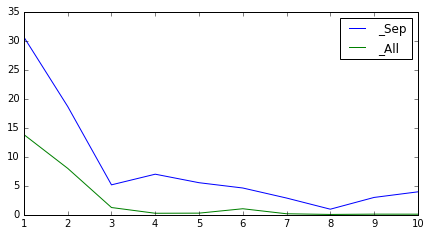

In [226]:
In_Anchs_Sep=[]
In_Anchs_Sep_means=[]
In_Anchs_Sep_meds=[]

In_Anchs_All=[]
In_Anchs_All_means=[]
In_Anchs_All_meds=[]

for position in range(1,11):
    In_Anchs_Sep.append(df_kw[df_kw.Position==position].In_Anch_Sep)
    In_Anchs_All.append(df_kw[df_kw.Position==position].In_Anch_All)
    
In_Anchs_Sep_means=[reject_outlier(arr).mean() for arr in In_Anchs_Sep]
In_Anchs_All_means=[reject_outlier(arr).mean() for arr in In_Anchs_All]

# In_Anchs_Sep_meds=[np.median(reject_outlier(arr)) for arr in In_Anchs_Sep]
# In_Anchs_All_meds=[np.median(reject_outlier(arr)) for arr in In_Anchs_All]

fig = plt.figure(1,figsize=(24,8))

# fig.add_subplot(231).boxplot(In_Anchs_Sep,patch_artist=True)
ax1=fig.add_subplot(231)
l1,l2 = ax1.plot(np.arange(1,11),In_Anchs_Sep_means,np.arange(1,11),In_Anchs_All_means)
ax1.legend((l1,l2),('_Sep','_All'))


# fig.add_subplot(234).boxplot(In_Anchs_All,patch_artist=True)
# fig.add_subplot(231).plot(np.arange(1,11),In_Anchs_All_means,label='_All')
# fig.add_subplot(236).plot(np.arange(1,11),In_Anchs_All_meds)


### Analysis for surrounding text

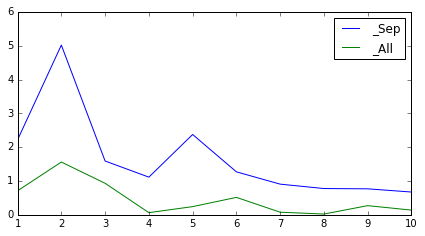

In [227]:
# plt.boxplot(df_kw.InSurr,10-df_kw.Position)
In_Surrs_Sep=[]
In_Surrs_Sep_means=[]
# In_Surrs_Sep_meds=[]
In_Surrs_All=[]
In_Surrs_All_means=[]
# In_Surrs_All_meds=[]

for position in range(1,11):
    In_Surrs_Sep.append(df_kw[df_kw.Position==position].In_Surr_Sep)
    In_Surrs_All.append(df_kw[df_kw.Position==position].In_Surr_All)
    
In_Surrs_Sep_means=[reject_outlier(arr).mean() for arr in In_Surrs_Sep]
In_Surrs_All_means=[reject_outlier(arr).mean() for arr in In_Surrs_All]

# In_Surrs_Sep_meds=[np.median(reject_outlier(arr)) for arr in In_Surrs_Sep]
# In_Surrs_All_meds=[np.median(reject_outlier(arr)) for arr in In_Surrs_All]

fig2 = plt.figure(2,figsize=(24,8))

ax1=fig2.add_subplot(231)
l1,l2 = ax1.plot(np.arange(1,11),In_Surrs_Sep_means,np.arange(1,11),In_Surrs_All_means)
ax1.legend((l1,l2),('_Sep','_All'))


# fig2.add_subplot(231).boxplot(In_Surrs_Sep,patch_artist=True)
# fig2.add_subplot(231).plot(np.arange(1,11),In_Surrs_Sep_means)
# fig2.add_subplot(233).plot(np.arange(1,11),In_Surrs_Sep_meds)

# fig2.add_subplot(234).boxplot(In_Surrs_All,patch_artist=True)
# fig2.add_subplot(232).plot(np.arange(1,11),In_Surrs_All_means)
# fig2.add_subplot(236).plot(np.arange(1,11),In_Surrs_All_meds)

### Analysis for page content

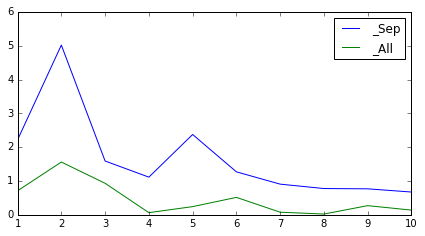

In [246]:
In_Pages_Sep=[]
In_Pages_Sep_means=[]
In_Pages_Sep_meds=[]

In_Pages_All=[]
In_Pages_All_means=[]
In_Pages_All_meds=[]

for position in range(1,11):
    In_Pages_Sep.append(df_kw[df_kw.Position==position].In_Page_Sep)
    In_Pages_All.append(df_kw[df_kw.Position==position].In_Page_All)
    
In_Pages_Sep_means=[reject_outlier(arr).mean() for arr in In_Pages_Sep]
In_Pages_All_means=[reject_outlier(arr).mean() for arr in In_Pages_All]

# In_Pages_Sep_meds=[np.median(reject_outlier(arr)) for arr in In_Pages_Sep]
# In_Pages_All_meds=[np.median(reject_outlier(arr)) for arr in In_Pages_All]

fig3 = plt.figure(3,figsize=(24,8))

ax1=fig3.add_subplot(231)
l1,l2 = ax1.plot(np.arange(1,11),In_Surrs_Sep_means,np.arange(1,11),In_Surrs_All_means)
ax1.legend((l1,l2),('_Sep','_All'))


# fig3.add_subplot(231).boxplot(In_Pages_Sep,patch_artist=True)
# fig3.add_subplot(231).plot(np.arange(1,11),In_Pages_Sep_means)
# fig3.add_subplot(233).plot(np.arange(1,11),In_Pages_Sep_meds)

# fig3.add_subplot(234).boxplot(In_Pages_All,patch_artist=True)
# fig3.add_subplot(232).plot(np.arange(1,11),In_Pages_All_means)
# fig3.add_subplot(236).plot(np.arange(1,11),In_Pages_All_meds)

### Analysis for keywords not present in anchor/surrounding text/page content

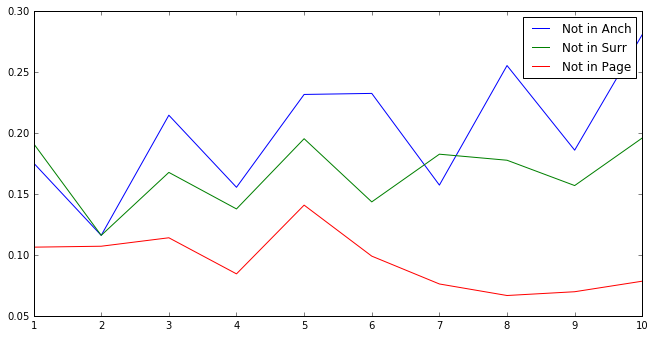

In [311]:
df=df_kw.groupby(['Position']).agg({'Traffic':'count','In_Anch':'mean','In_Surr':'mean','In_Page':'mean'})
df['Not_In_Anch']=1-df['In_Anch']
df['Not_In_Surr']=1-df['In_Surr']
df['Not_In_Page']=1-df['In_Page']
# print(df)

fig4 = plt.figure(4,figsize=(24,12))
ax1=fig4.add_subplot(221)
l1,l2,l3=ax1.plot(range(1,11),df.Not_In_Anch,range(1,11),df.Not_In_Surr,range(1,11),df.Not_In_Page)
ax1.legend((l1,l2,l3),('Not in Anch','Not in Surr','Not in Page'))